# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimisation

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2020-09-21,2960.469971,24.469999,339.570007,125.410004,404.970001,49.090000,216.410004,202.539993,3.64,83.889999
2020-09-22,3128.989990,23.940001,344.450012,127.209999,413.750000,49.660000,216.410004,207.419998,3.68,83.949997
2020-09-23,2999.860107,23.260000,344.630005,123.279999,413.540009,48.209999,214.970001,200.589996,3.52,82.989998
2020-09-24,3019.790039,23.340000,347.000000,122.489998,413.299988,48.700001,216.119995,203.190002,3.42,83.040001
2020-09-25,3095.129883,23.490000,342.579987,124.000000,418.079987,48.720001,218.179993,207.820007,3.50,84.300003


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    26.079659
1993-02-01    26.265144
1993-02-02    26.320782
1993-02-03    26.599014
1993-02-04    26.710312
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 1572709072896,
 'AMZN': 1550319616000,
 'NAT': 523915008,
 'BAC': 203519705088,
 'DPZ': 16450276352,
 'DIS': 224075431936,
 'KO': 209273831424,
 'MCD': 162348384256,
 'COST': 151257284608,
 'SBUX': 98546696192}

## Constructing the prior

In [6]:
import pypfopt
pypfopt.__version__

'1.2.6'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5042720332949346

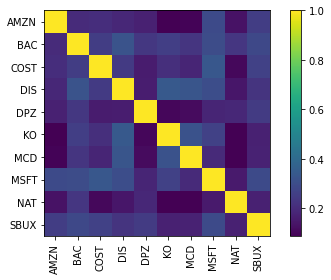

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.186297
BAC     0.097458
COST    0.072619
DIS     0.090984
DPZ     0.046408
KO      0.060938
MCD     0.065935
MSFT    0.124995
NAT     0.050317
SBUX    0.077127
dtype: float64

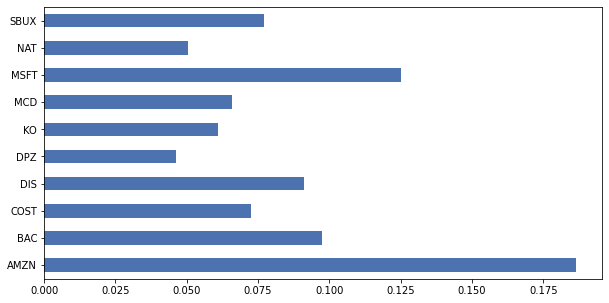

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

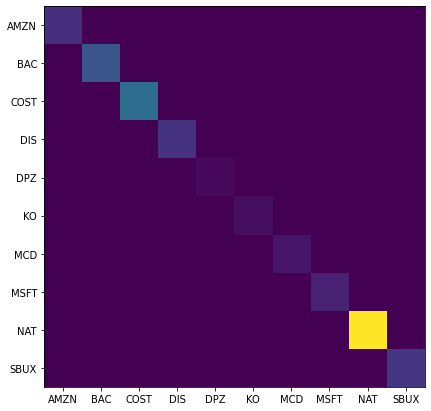

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.00459711, 0.00898261, 0.01214912, 0.00496483, 0.00080342,
       0.00125652, 0.00196954, 0.00344805, 0.03411678, 0.00538573])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.163210
BAC     0.133672
COST    0.059840
DIS     0.072451
DPZ     0.101367
KO      0.004367
MCD     0.108194
MSFT    0.101974
NAT     0.060748
SBUX    0.082197
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.186297,0.163210,0.10
BAC,0.097458,0.133672,0.30
COST,0.072619,0.059840,0.05
DIS,0.090984,0.072451,0.05
DPZ,0.046408,0.101367,0.20
KO,0.060938,0.004367,-0.05
MCD,0.065935,0.108194,0.15
MSFT,0.124995,0.101974,0.10
NAT,0.050317,0.060748,0.50
SBUX,0.077127,0.082197,0.10


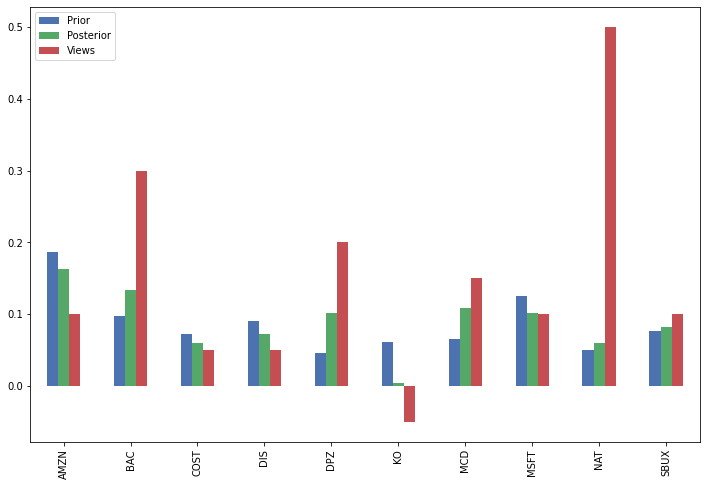

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

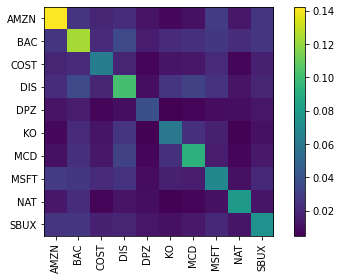

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/Robert/github/PyPortfolioOpt/pypfopt/efficient_frontier.py:195: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.20736),
             ('BAC', 0.1601),
             ('COST', 0.05112),
             ('DIS', 0.06412),
             ('DPZ', 0.12888),
             ('KO', 0.0),
             ('MCD', 0.13033),
             ('MSFT', 0.11788),
             ('NAT', 0.05521),
             ('SBUX', 0.08501)])

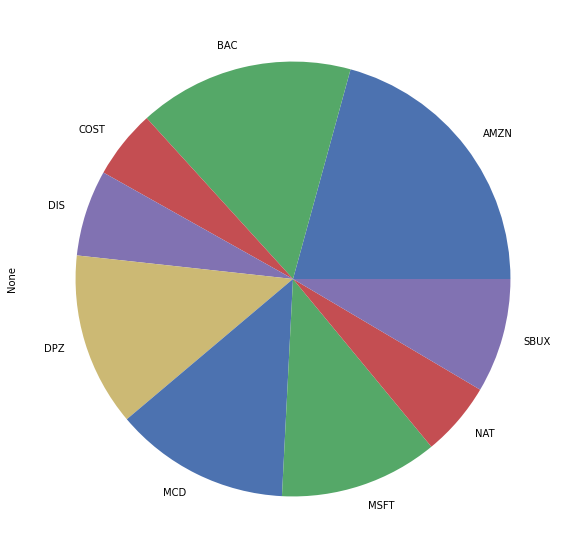

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $39.10


{'AMZN': 1,
 'BAC': 137,
 'COST': 3,
 'DIS': 11,
 'DPZ': 7,
 'KO': 7,
 'MCD': 12,
 'MSFT': 12,
 'NAT': 316,
 'SBUX': 21}